<a href="https://colab.research.google.com/github/michalovsky/character_prediction/blob/master/character_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.utils import np_utils
import numpy as np
import os
import re
import time
import string
import glob

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


In [0]:
# Devices informations
print("Devices:\n", device_lib.list_local_devices())
print("GPU:", tf.test.gpu_device_name())

Devices:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14201578251494713768
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9328478204569165466
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4715314578553899572
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10362487417246095800
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books_data.git

In [0]:
# Read all file paths from directory
directory1 = "books_data/shelley/"
directory2 = "books_data/kafka/"
directory3 = "books_data/sienkiewicz/"
directory4 = "books_data/joyce/"

directory = directory2
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 1 text files in directory: books_data/kafka/


In [0]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r') as file:
        file_content = file.read()
        #remove file beginning and ending from gutenberg books
        file_content = file_content[file_content.find("*** START"):file_content.rfind("*** END")]
        #remove file ending from wolnelektury books
        file_content = file_content[:file_content.rfind("-----")]
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 119433 characters


In [0]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“', '          ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéô', 'acelnoszzaoueeeeo', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "rozdzial <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)

# remove "chapter <number>" strings 
text = re.sub(r"\nchapter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

Length of text after preprocessing: 115574 characters


In [0]:
# Creating a mapping from unique characters to indices

vocab = sorted(set(text))
vocab_length = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

#encode text from characters to numbers  
encoded = np.array([char2idx[ch] for ch in text])  

In [0]:
# Print unique characters
print ('{} unique characters:'.format(len(vocab)))

print('{')
for char in char2idx:
    print('  {:4s}:{:3d},'.format(repr(char), char2idx[char]))
print('}')

27 unique characters:
{
  ' ' :  0,
  'a' :  1,
  'b' :  2,
  'c' :  3,
  'd' :  4,
  'e' :  5,
  'f' :  6,
  'g' :  7,
  'h' :  8,
  'i' :  9,
  'j' : 10,
  'k' : 11,
  'l' : 12,
  'm' : 13,
  'n' : 14,
  'o' : 15,
  'p' : 16,
  'q' : 17,
  'r' : 18,
  's' : 19,
  't' : 20,
  'u' : 21,
  'v' : 22,
  'w' : 23,
  'x' : 24,
  'y' : 25,
  'z' : 26,
}


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sequence_length = 100

x_data = []
y_data = []

for i in range(0, len(text) - sequence_length, 1):
    x_sequence = text[i:i + sequence_length]
    y_label = text[i + sequence_length]

    x_data.append([char2idx[char] for char in x_sequence])
    y_data.append(char2idx[y_label])

data_length = len(x_data)
print("Amount of data", data_length)

X = np.reshape(x_data, (data_length, sequence_length, 1))
X = X/float(vocab_length)
y = np_utils.to_categorical(y_data)

# Split into training and testing set, shuffle data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

# Shuffle testing set
X_test, y_test = shuffle(X_test, y_test, random_state=0)

Amount of data 115474


In [101]:
model = Sequential()
model.add(LSTM(330, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(330))
model.add(Dense(y.shape[1], activation='softmax'))

#TO CHECK
# kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)



# model = Sequential()
# model.add(LSTM(600, return_sequences=True, input_shape=(X.shape[1], X.shape[2]), recurrent_initializer='glorot_uniform', recurrent_dropout=0.3))
# model.add(Dropout(0.4))
# model.add(LSTM(600, recurrent_initializer='glorot_uniform', recurrent_dropout=0.3))
# model.add(Dropout(0.4)) #none to 0.4
# model.add(Dense(y.shape[1], activation='softmax'))
# NIGHT CHECK, batch_size=64, sequences=30

# model = Sequential()
# model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True, recurrent_initializer='glorot_uniform', recurrent_dropout=0.3))
# # model.add(Dropout(0.4))
# model.add(LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform', recurrent_dropout=0.3))
# # model.add(Dropout(0.4))
# model.add(LSTM(256, recurrent_initializer='glorot_uniform', recurrent_dropout=0.3))
# model.add(Dropout(0.2))
# model.add(Dense(y.shape[1], activation='softmax'))

# Model informations
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100, 330)          438240    
_________________________________________________________________
lstm_34 (LSTM)               (None, 330)               872520    
_________________________________________________________________
dense_16 (Dense)             (None, 27)                8937      
Total params: 1,319,697
Trainable params: 1,319,697
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Setting checkpoints and directory to save weights

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)

# filepath="epoch-{epoch:02d}-loss-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')

callbacks = [es]

In [0]:
epochs = 50
batch_size = 64 #128->64
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 92379 samples, validate on 23095 samples
Epoch 1/50
92379/92379 - 44s - loss: 2.5983 - accuracy: 0.2540 - val_loss: 2.2829 - val_accuracy: 0.3383
Epoch 2/50
92379/92379 - 41s - loss: 2.0537 - accuracy: 0.3983 - val_loss: 1.9693 - val_accuracy: 0.4220
Epoch 3/50
92379/92379 - 41s - loss: 1.7796 - accuracy: 0.4725 - val_loss: 1.8081 - val_accuracy: 0.4645
Epoch 4/50
92379/92379 - 41s - loss: 1.6216 - accuracy: 0.5169 - val_loss: 1.7014 - val_accuracy: 0.4950
Epoch 5/50
92379/92379 - 41s - loss: 1.5023 - accuracy: 0.5516 - val_loss: 1.6469 - val_accuracy: 0.5118
Epoch 6/50
92379/92379 - 41s - loss: 1.4114 - accuracy: 0.5734 - val_loss: 1.6200 - val_accuracy: 0.5190
Epoch 7/50
92379/92379 - 41s - loss: 1.3355 - accuracy: 0.5950 - val_loss: 1.6213 - val_accuracy: 0.5252
Epoch 8/50
92379/92379 - 41s - loss: 1.2650 - accuracy: 0.6162 - val_loss: 1.6293 - val_accuracy: 0.5253
Epoch 9/50
92379/92379 - 41s - loss: 1.2032 - accuracy: 0.6321 - val_loss: 1.6129 - val_accuracy: 0.5319
Epoch

In [45]:
tf.train.latest_checkpoint(checkpoint_dir) #second param direct file: "ckpt_50"

'./training_checkpoints/ckpt_30'

In [0]:
def generate_text(model):
  random_index = np.random.randint(0, len(X)-1)
  new_string = x_data[random_index]
  print ('random seed data: ', repr(''.join(idx2char[new_string])))

  text_generated = []

  model.reset_states()
  for i in range(100):
      x = np.reshape(new_string, (1, len(new_string), 1))
      x = x/float(vocab_length)

      index = np.argmax(model.predict(x))
      result = idx2char[index]

      new_string = np.append(new_string, index)
      new_string = new_string[1:len(new_string)]
      text_generated.append(result)

  return ''.join(text_generated)

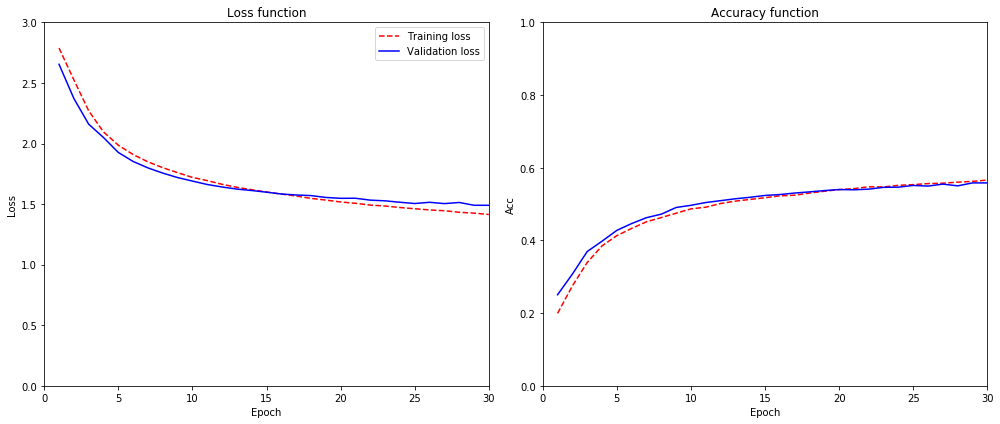

In [59]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [0]:
#Save model summary, weights, params and plots to file
from contextlib import redirect_stdout

save_directory = "save"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

with open(save_directory+"/model_summary.txt", 'w') as f:
    with redirect_stdout(f):
        model.summary()

with open(save_directory+"/data_info.txt", 'w') as f:
    with redirect_stdout(f):
        print("Data:", directory)
        print("Amount of data:", data_length)
        print("Sequence length", sequence_length)
        print("Batch size:", batch_size)
        print("Epochs:", epochs)

model.save_weights(save_directory+"/weights.h5")

plt.savefig(save_directory+"/characteristics.png")  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [63]:
print(generate_text(model))
# margaret tried up the home that noone else way his head kep

random seed data:  'dow while gregors father observed them a'
nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
